<a href="https://colab.research.google.com/github/dmadea/Photo-Kinetic-Simulator/blob/main/Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Photokinetic Simulator

This notebook allows you to create a compartmental models from simple text-based input. The system of ordinary differential equations (ODEs) can be displayed and steady state approximation for transient species can be performed symbolically. Symbolic manipulations are performed with [Sympy](https://www.sympy.org/en/index.html) module. The compartmental model can be simulated for different input parameters and initial concentrations. Multiple compartments can absorb light, thereby having different epsilon values used as input parameters, however the model is simulating the case where the solution is irradiated only with one irradiation wavelength. 

### Rules for the Input Text Model

Expected format of the text-based input is single or multiline, forward reactions and absorptions are denoted with `-->` and `-hv->` signs, respecively. Names of compartments are case sensitive. It is possible to denote the sub- and/or superscript with $\LaTeX$ notation (for details, see the corresponding [tutorial](https://cs.overleaf.com/learn/latex/Mathematical_expressions)):

* `^1S` $\rightarrow$ $\mathrm{^1S}$ 
* `^1O_2`  $\rightarrow$   $\mathrm{^1O_2}$
*  `RB^{\bullet 3-}` $\rightarrow$   $\mathrm{RB^{\bullet 3-}}$

Names of the rate constants for individual reactions can be taken from the text input. They can be denoted at the end of the each line after `//` characters and are separated by semicolon `;`. It means, that semicolon cannot appear in the name of the rate constant (this could be improved in the future). If the rate constant name is not specified, default name using the reactants and products will be used. Comments are denoted by `#`. All characters after this symbol will be ignored. The rate constants can be specified in $\LaTeX$ notation:

* `k_r` $\rightarrow$ $k_r$ 
* `k_{isc}` $\rightarrow$ $k_{isc}$
* `k_d^{\prime}` $\rightarrow$ $k_d^{\prime}$

*Note: The backslash in the $\LaTeX$ notation (e.g. \prime, \bullet) have to be escaped in the text model (see later).*

### Simulation of the Model

The rate constants, intial concentrations and epsilon values has to be supplied in the order they are stored in the model. To see the correct order, print the following attributes of the instantiated model:

* `symbols['rate_constants']`
* `symbols['compartments']`
* `symbols['epsilons']`

In the case of making substitutions during the symbolic steady state approximation, the substituted parameters has to be supplied to the model as well. Only expressions composed of rate_constants can be substituted. The order of the substituted parameters can be found in following attribute:

* `symbols['substitutions']`

### Units

In default, the concentrations are denoted in $\mathrm{M = mol\ L^{-1}}$. The concentration is specified in a model as `concentration_unit`. Time is always supplied in seconds. For simulation, the automatic unit conversion is performed, but this can be disabled with option `auto_convert_time_units` in `simulate_model` function. The units of rate constants are automatically determined from the model, but the time unit is always in seconds: 

$$[k] = \mathrm{M^{1 - [\text{rate order}]}\ s^{-1}}$$

In the case of photoreactions, the symbol $J_0$ is the "concentration of photons" that hits the sample. Usual unit is $[J] = \mathrm{M \ s^{-1}}$:

$$J_0 = \frac{q_0}{V}$$

Here, $q_0$ is the incident photon flux (usually in $\mathrm{mol\ s^{-1}}$) and $V$ is the volume of the sample in the cuvette (usually in $\mathrm L$).

#### Photokinetic factor

In a photo-reactions where multiple species absorb light, the photokientic factor $F_k$ very often arises. It is defined as:

$$F_k(t) = \frac{1 - 10^{-A(t)}}{A(t)}$$

where $A(t)$ is the total absorbance of the solution. In this simulator, a slight variation of photokinetic factor is be used:

$$F_k(t) = \frac{1 - 10^{-lA^{\prime}(t)}}{A^{\prime}(t)} \qquad A^{\prime}(t) = \sum\varepsilon_i c_i(t)$$ 

where $\varepsilon$ is molar absorption coefficient at irradiation wavelength in $\mathrm{M^{-1}\ cm^{-1}}$, $c_i(t)$ are concentrations of comparments and $l$ is path length in $\mathrm{cm}$. For the usage of the symbolic model, see the examples below.


### Irradiation modes

To setup a mode, change `flux_type` variable in the instantiated model. The model can be simulated with 3 modes: Steady-state or continuous (`flux_type = "Continuous"`), Gaussian pulse (`flux_type = "Gaussian pulse"`) and square pulse (`flux_type = "Square pulse"`). Under steady-state conditions, the intensity is const. in time:

$$J(t) = J_0$$

The Gaussian pulse that is located at $t = 0$ is specified with additional parameter $FWHM$ which has to be supplied in the model as `gaussian_FWHM` argument to `simulate_model` method:


$$J(t) = J_0 \frac{2\sqrt{\ln{2}}}{FWHM\sqrt\pi}\exp\left(-\frac{4t^2 \ln2}{FWHM^2}\right)$$

The square pulse t is specified with additional parameter $s_w$ which has to be supplied in the model as `square_pulse_width` argument to `simulate_model` method:


$$J(t) = 
\begin{cases}
0, & t < 0 \\
J_0, & 0 \leq t \leq s_w \\
0, & t > s_w
\end{cases}$$



In [1]:
#@title Install and Load Packages { display-mode: "form" }

#@markdown Please execute this cell by pressing the _Play_ button 
#@markdown on the left to download and import the required packages 
#@markdown in this Colab notebook.

#@markdown **Note**: This installs the sympy package on the Colab 
#@markdown notebook in the cloud and not on your computer.

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

try:
    import sympy
except ImportError:
    %shell pip install sympy

from sympy import symbols, Symbol, print_latex, Eq
from IPython.display import display, Latex, HTML
import matplotlib.pyplot as plt
import numpy as np

try:
    import kin_model
except ImportError:
    %shell wget -q "https://raw.githubusercontent.com/dmadea/Photo-Kinetic-Simulator/main/kin_model.py"

from kin_model import PhotoKineticSymbolicModel

In [2]:
#@title Fontsize of the Output Cells and Figures { display-mode: "form", run: "auto" }

#@markdown Set the fontsize of the text in output cells and graphs,
#@markdown default value is 18px and 14, respectively. 

#@markdown **Note**: In order for the change to have an effect
#@markdown you have to rerun the cells.

font_size = 18#@param {type:"integer"}
figures_font_size = 14#@param {type:"integer"}

# from https://stackoverflow.com/questions/61957742/how-to-increase-font-size-of-google-colab-cell-output
def increase_font():
    # set font size and ticks widths of matplotlib figures
    plt.rcParams.update({'font.size': figures_font_size})
    plt.rcParams.update({'xtick.major.size': 5, 'ytick.major.size': 5})
    plt.rcParams.update({'xtick.minor.size': 2.5, 'ytick.minor.size': 2.5})
    plt.rcParams.update({'xtick.major.width': 1, 'ytick.major.width': 1})
    plt.rcParams.update({'xtick.minor.width': 0.8, 'ytick.minor.width': 0.8})

    from IPython.display import Javascript
    display(Javascript(f'''
    for (rule of document.styleSheets[0].cssRules){{
        if (rule.selectorText=='body') {{
            rule.style.fontSize = '{font_size}px'
            break
        }}
    }}'''))

# from https://colab.research.google.com/gist/blois/2e6a1299b8fd5704974dc67f47323deb/copy-of-latex-render-fail.ipynb
# def typeset():
#     """MathJax initialization for the current cell.

#     This installs and configures MathJax for the current output.
#     """
#     display(HTML("""
#         <script src="https://www.gstatic.com/external_hosted/mathjax/latest/MathJax.js?config=TeX-AMS_HTML-full,Safe&delayStartupUntil=configured"></script>
#         <script>
#         (() => {
#             const mathjax = window.MathJax;
#             mathjax.Hub.Config({
#             'tex2jax': {
#             'inlineMath': [['$', '$'], ['\\(', '\\)']],
#             'displayMath': [['$$', '$$'], ['\\[', '\\]']],
#             'processEscapes': true,
#             'processEnvironments': true,
#             'skipTags': ['script', 'noscript', 'style', 'textarea', 'code'],
#             'displayAlign': 'center',
#             },
#             'HTML-CSS': {
#             'styles': {'.MathJax_Display': {'margin': 0}},
#             'linebreaks': {'automatic': true},
#             // Disable to prevent OTF font loading, which aren't part of our
#             // distribution.
#             'imageFont': null,
#             },
#             'messageStyle': 'none'
#         });
#         mathjax.Hub.Configured();
#         })();
#         </script>
#         """))
  
if IN_COLAB:
    # set it to run in every cell
    get_ipython().events.register('pre_run_cell', increase_font)
    # get_ipython().events.register('pre_run_cell', typeset)

    # disable
    # get_ipython().events.unregister('pre_run_cell', increase_font)

### Simple Sequential Kinetic Model

In the following example, the simulation of simple sequential model is shown. The individual operations are explained by the code comments.

In [3]:
# define a sequential kinetic model
text_model = """
A --> B --> C --> D 
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(text_model)
le = model.print_model()  # print the model
model.pprint_equations()  # print the ODEs
model.get_par_dict()   # get the parameter dictionary, we will use this to get the model the input parameters

<IPython.core.display.Math object>

Eq(Derivative(c_{A}(t), t), -k_{AB}*c_{A}(t))

Eq(Derivative(c_{B}(t), t), k_{AB}*c_{A}(t) - k_{BC}*c_{B}(t))

Eq(Derivative(c_{C}(t), t), k_{BC}*c_{B}(t) - k_{CD}*c_{C}(t))

Eq(Derivative(c_{D}(t), t), k_{CD}*c_{C}(t))

{'c_A_0': None,
 'c_B_0': None,
 'c_C_0': None,
 'c_D_0': None,
 'k_AB': None,
 'k_BC': None,
 'k_CD': None,
 'l': 1,
 's_w': 1,
 'J_0': 1e-05,
 'FWHM': 1}

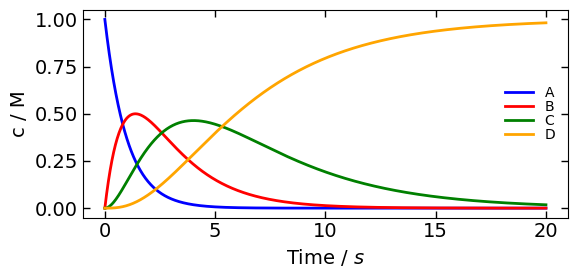

In [8]:
#  parameters l, s_w, J_0 and FWHM we don't need but they need to be specified
pars = { 'c_A_0': 1,
         'c_B_0': 0,
         'c_C_0': 0,
         'c_D_0': 0,
         'k_AB': 1,
         'k_BC': 0.5,
         'k_CD': 0.25,
         'l': 1,   
         's_w': 1,
         'J_0': 1e-05,
         'FWHM': 1}

# simulate the model, t_max is the last time point of the simulation
model.simulate_model(pars, t_max=20)
model.plot_simulation_results(plot_separately=False)

### Simple Photokinetic Model

In the following example, the ground state of a compound absorbs the light and forms a singlet state. It mainly decays back to the ground state, but some will lead to photoreaction to form a product. The purpose is to simulate the time profile of the ground state. Because singlet state lifetime is much shorter than the time changes of the overall steady state reaction, we will make the steady state approximation for the singlet state.

In [5]:
# Here are the possible irradiation modes
PhotoKineticSymbolicModel.Flux_types

['Gaussian pulse', 'Square pulse', 'Continuous']

In [6]:
text_model = """
GS -hv-> ^1S --> GS  // k_s  # absorption and decay back to ground state
^1S --> P            // k_r  # formation of the photoproduct from the singlet state
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(text_model)
model.flux_type = model.Flux_types[2]  # set the Continuous mode (steady-state)
model.print_model()  # print the model
model.pprint_equations()  # print the ODEs
print('\n')

# make steady state approximation for the singlet state
model.steady_state_approx(['^1S'])

print('\nTo make things easier, we will make the following substitutions:')

ks, kr = model.symbols['rate_constants']
phi_r, tau_F = symbols('\\phi_r, \\tau_F')

print('\n')
# Fluorescence lifetime is inverse of total decay rate of the singlet state
# Quantum yield of the photoreaction is then k_r * fluorescence lifetime
subs=[(1/(ks+kr), tau_F), (kr * tau_F, phi_r)]
for old, new in subs:
    display(Eq(old, new))

print('\nSteady state approximation for singlet state with applied substitutions:')

# perform the steady state approximation for singlet state with applied substitutions
model.steady_state_approx(['^1S'], subs=subs)
model.get_par_dict()   # get the parameter dictionary, we will use this to get the model the input parameters

<IPython.core.display.Math object>

Eq(J(t), J_0)

Eq(F_k(t), (1 - 1/10**(\varepsilon_{GS}*l*c_{GS}(t)))/(\varepsilon_{GS}*c_{GS}(t)))

Eq(Derivative(c_{GS}(t), t), -\varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t) + k_s*c_{^1S}(t))

Eq(Derivative(c_{^1S}(t), t), \varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t) - k_r*c_{^1S}(t) - k_s*c_{^1S}(t))

Eq(Derivative(c_{P}(t), t), k_r*c_{^1S}(t))

Eq(J(t), J_0)

Eq(F_k(t), (1 - 1/10**(\varepsilon_{GS}*l*c_{GS}(t)))/(\varepsilon_{GS}*c_{GS}(t)))

Eq(c_{^1S}(t), \varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t)/(k_r + k_s))

Eq(Derivative(c_{GS}(t), t), -\varepsilon_{GS}*k_r*F_k(t)*J(t)*c_{GS}(t)/(k_r + k_s))

Eq(Derivative(c_{P}(t), t), \varepsilon_{GS}*k_r*F_k(t)*J(t)*c_{GS}(t)/(k_r + k_s))


To make things easier, we will make the following substitutions:




Eq(1/(k_r + k_s), \tau_F)

Eq(\tau_F*k_r, \phi_r)


Steady state approximation for singlet state with applied substitutions:


Eq(J(t), J_0)

Eq(F_k(t), (1 - 1/10**(\varepsilon_{GS}*l*c_{GS}(t)))/(\varepsilon_{GS}*c_{GS}(t)))

Eq(c_{^1S}(t), \tau_F*\varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t))

Eq(Derivative(c_{GS}(t), t), -\phi_r*\varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t))

Eq(Derivative(c_{P}(t), t), \phi_r*\varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t))

{'c_GS_0': None,
 'c_^1S_0': None,
 'c_P_0': None,
 'k_s': None,
 'k_r': None,
 'epsilon_GS': None,
 'phi_r': None,
 'tau_F': None,
 'l': 1,
 's_w': 1,
 'J_0': 1e-05,
 'FWHM': 1}

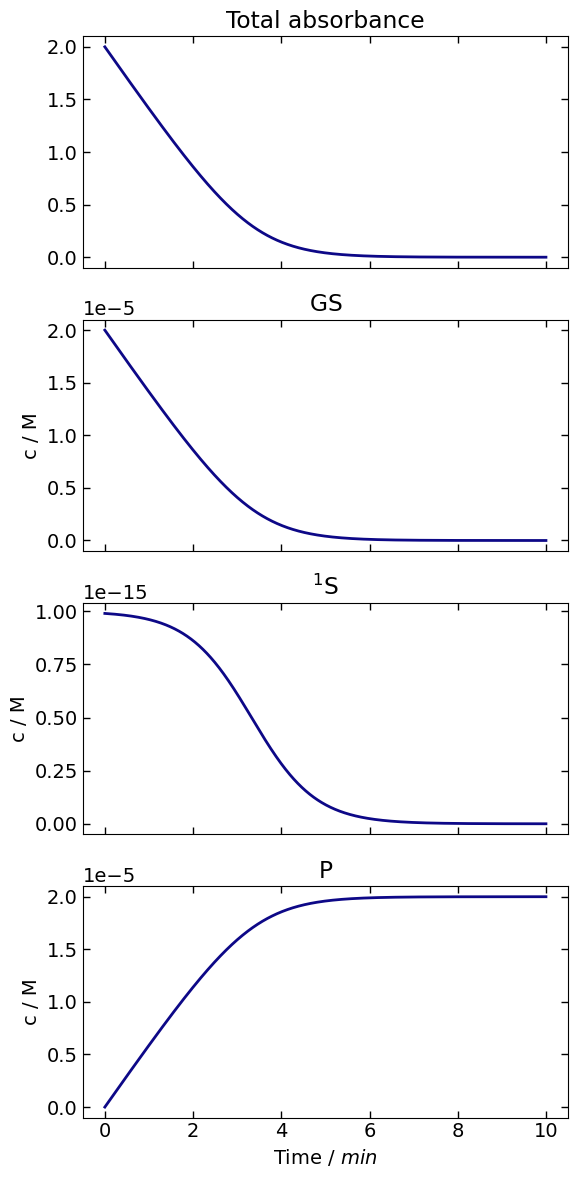

In [8]:
# set the input parameters, even though we don't need rate constants, they need to be defined, 
# but their value will not be used under conditions of substitutions

pars = { 'c_GS_0': 2e-5,
         'c_^1S_0': 0,
         'c_P_0': 0,
         'k_s': 1,
         'k_r': 1,
         'epsilon_GS': 1e5,
         'phi_r': 0.1,
         'tau_F': 1e-9,  # 1 ns lifetime
         'l': 1,   # cuvette length
         's_w': 1,
         'J_0': 1e-06,  # incident photon flux
         'FWHM': 1}

model.simulate_model(pars, t_max=600)
model.plot_simulation_results(plot_separately=True)

### Two photon ionization - Transient mode

In the following example, the ground state of a compound absorbs the light and forms a singlet state, which may absorb a second photon, creating a product which does not absorb. Because during the intergration, the rate of production of product depends on the square of the intensity, it should be solved with space-dependent model, where $x \in [0, l]$ is the distance the light traveled, and light intensity is dependent on $x$. Unfortunatelly, this cannot be done yet. At the end, we plot the dependency of the product (the amount of starting material that was ionized) to the pulse energy. The curve shows non-linear behaviour.

In [9]:
text_model = """
GS -hv-> ^1S --> GS  // k_s  # absorption and decay back to ground state
^1S -hv-> P            //   # formation of the photoproduct from the singlet state
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(text_model)
model.flux_type = model.Flux_types[0]  # set the Gaussian pulse mode 
model.print_model()  # print the model
model.pprint_equations()  # print the ODEs
# there will be no steady-state approximation
model.get_par_dict()   # get the parameter dictionary, we will use this to get the model the input parameters

<IPython.core.display.Math object>

Eq(J(t), 2*J_0*exp(-4*t**2*log(2)/FWHM**2)*sqrt(log(2))/(sqrt(pi)*FWHM))

Eq(F_k(t), (1 - 1/10**(l*(\varepsilon_{GS}*c_{GS}(t) + \varepsilon_{^1S}*c_{^1S}(t))))/(\varepsilon_{GS}*c_{GS}(t) + \varepsilon_{^1S}*c_{^1S}(t)))

Eq(Derivative(c_{GS}(t), t), -\varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t) + k_s*c_{^1S}(t))

Eq(Derivative(c_{^1S}(t), t), \varepsilon_{GS}*F_k(t)*J(t)*c_{GS}(t) - \varepsilon_{^1S}*F_k(t)*J(t)*c_{^1S}(t) - k_s*c_{^1S}(t))

Eq(Derivative(c_{P}(t), t), \varepsilon_{^1S}*F_k(t)*J(t)*c_{^1S}(t))

{'c_GS_0': None,
 'c_^1S_0': None,
 'c_P_0': None,
 'k_s': None,
 'epsilon_GS': None,
 'epsilon_^1S': None,
 'l': 1,
 's_w': 1,
 'J_0': 1e-05,
 'FWHM': 1}

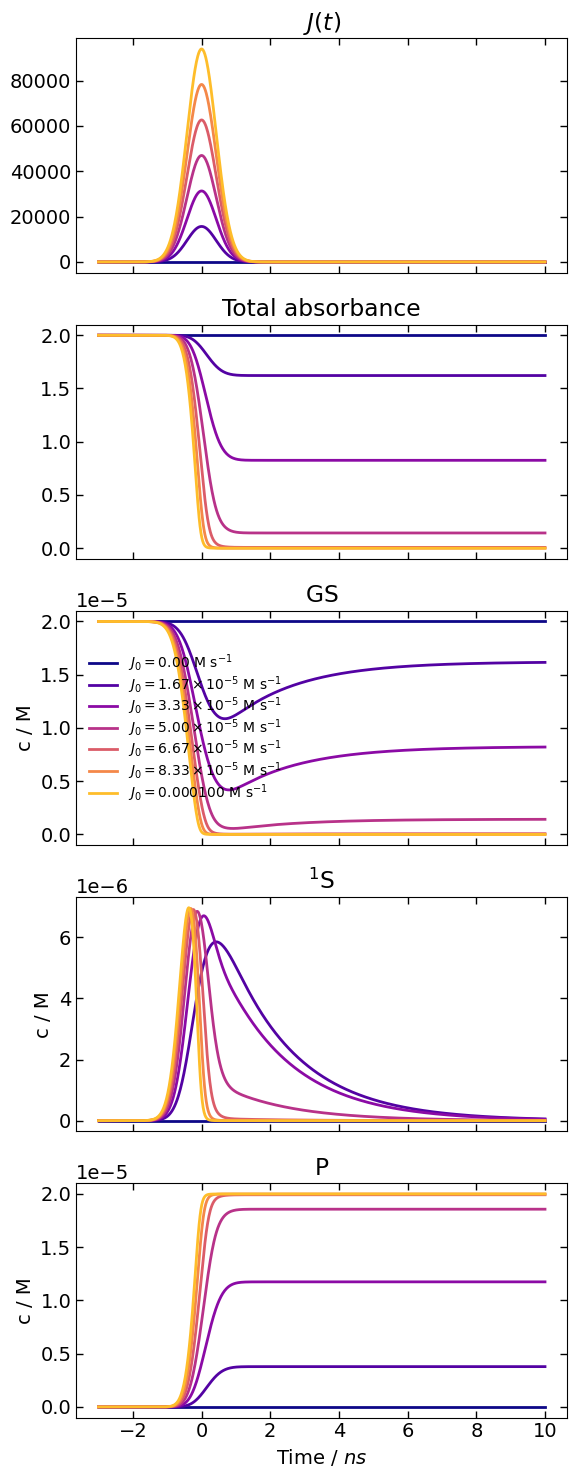

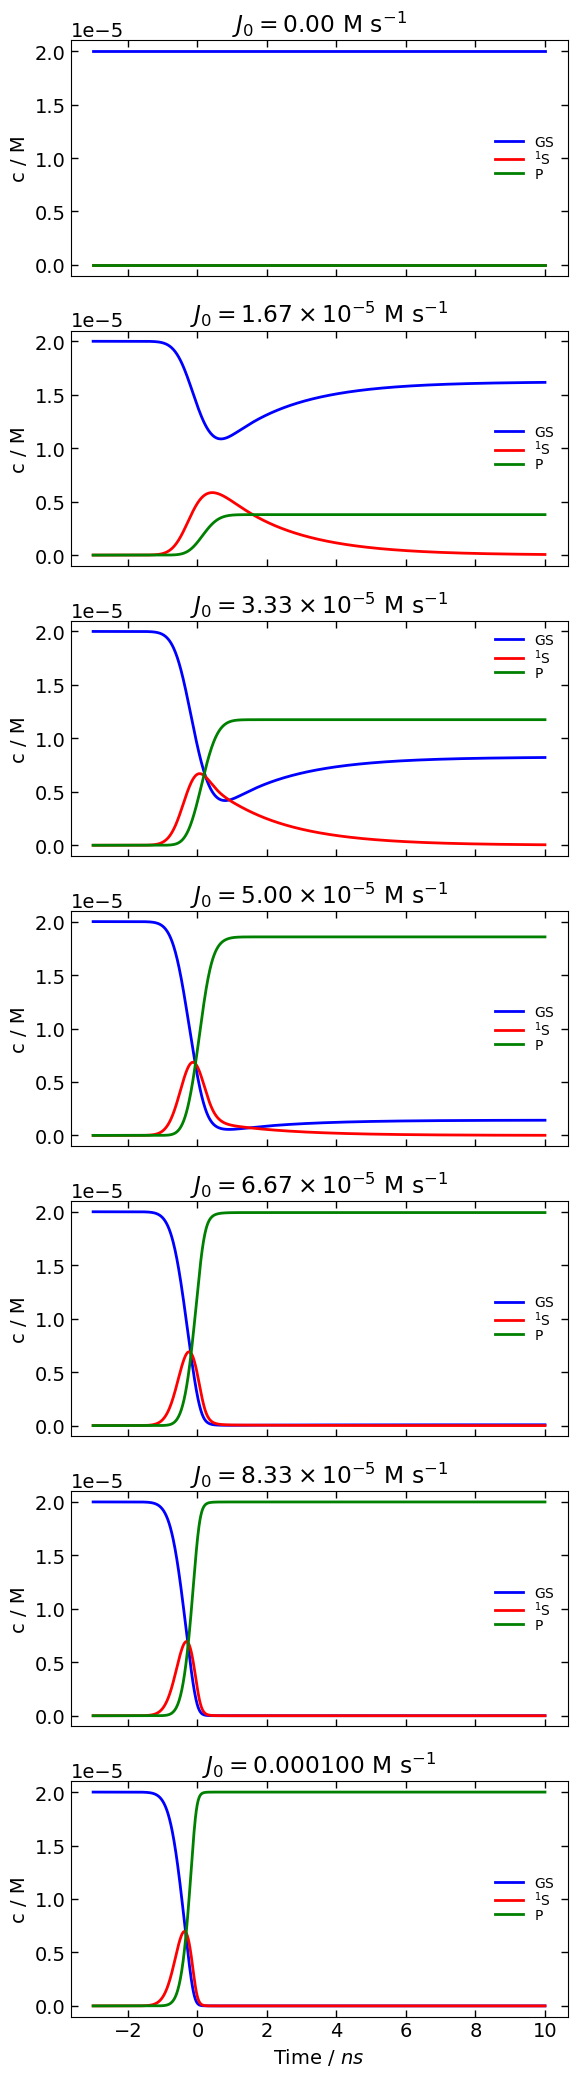

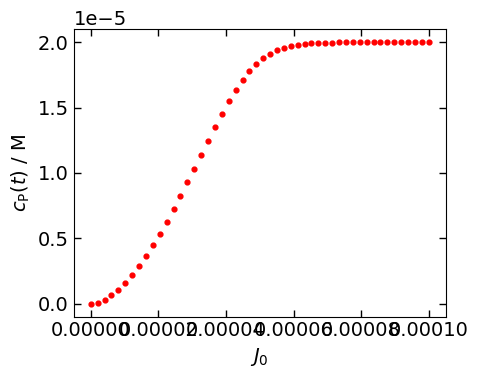

In [12]:
# set the input parameters, even though we don't need rate constants, they need to be defined, 
# but their value will not be used under conditions of substitutions

pars = { 'c_GS_0': 2e-5,
         'c_^1S_0': 0,
         'c_P_0': 0,
         'k_s': 5e8,
         'epsilon_GS': 1e5,
         'epsilon_^1S': 1e5,
         'l': 1,
         's_w': 1,
         'J_0': np.linspace(0, 1e-4, 7),
         'FWHM': 1e-9}  # 1 ns pulse  

t_max = 1e-8  # window 10 ns 

model.simulate_model(pars, t_max=t_max)
model.plot_simulation_results(plot_separately=True)
model.plot_simulation_results(plot_separately=False)

# plot dependency of final concentration of the product to pulse energy
pars['J_0'] = np.linspace(0, 1e-4, 50) # resimulate with more points
model.simulate_model(pars, t_max=t_max)
model.plot_depenency("J_0", "P", data_type="last", plot_type='scatter')

### SIR Epidemic Model

In the following example, the SIR model for epidemic is simulated.

In [16]:
str_model = """
Susceptible + Infected --> 2Infected // k_t   # transmission rate
Infected --> Recovered               // k_r   # recovery rate
Infected --> Dead                    // k_d   # death rate
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
model.pprint_equations()
pars = model.get_par_dict()   # get the parameter dictionary, we will use this to get the model the input parameters

<IPython.core.display.Math object>

Eq(Derivative(c_{Susceptible}(t), t), -k_t*c_{Infected}(t)*c_{Susceptible}(t))

Eq(Derivative(c_{Infected}(t), t), -k_d*c_{Infected}(t) - k_r*c_{Infected}(t) + k_t*c_{Infected}(t)*c_{Susceptible}(t))

Eq(Derivative(c_{Recovered}(t), t), k_r*c_{Infected}(t))

Eq(Derivative(c_{Dead}(t), t), k_d*c_{Infected}(t))

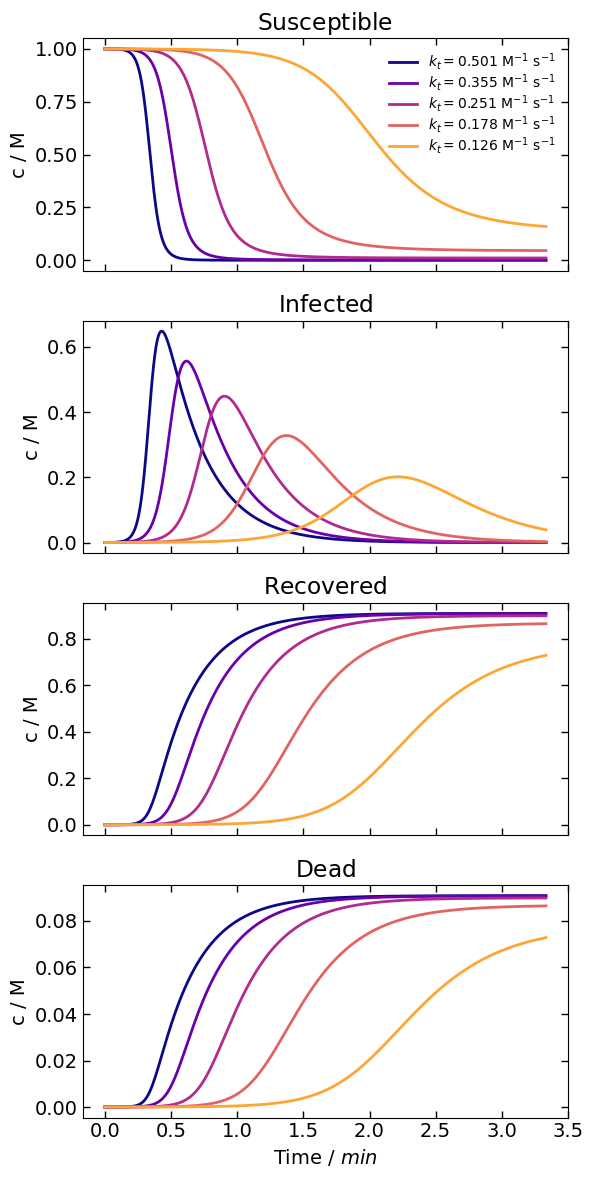

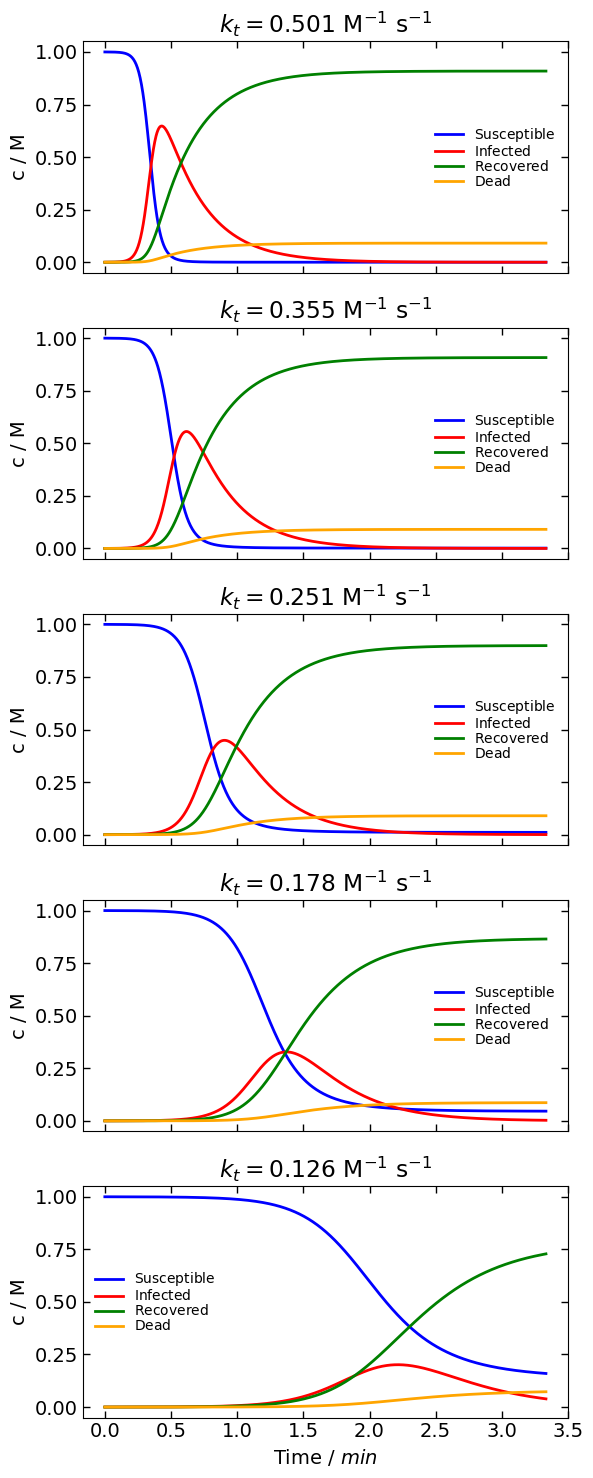

In [17]:
pars.update({ 'c_Susceptible_0': 1,
         'c_Infected_0': 1e-4,
         'c_Recovered_0': 0,
         'c_Dead_0': 0,
         'k_t': np.logspace(-0.3, -0.9, 5),
         'k_r': 0.05,
         'k_d': 0.005
})


# simulate the model, the model will simulated 5 times for 5 different transmission rates
model.simulate_model(pars, t_max=2e2)
model.plot_simulation_results(plot_separately=True)
model.plot_simulation_results(plot_separately=False)

### Transient Kinetics of Rose Bengal

In the following example, the transient kinetics of Rose Bengal under degassed conditions will be simulated. The kinetic model is based on our [publication](https://pubs.rsc.org/en/content/articlelanding/2016/cp/c6cp01710j#!divAbstract). The rate data for MeCN were used. Because the singlet state lifetime is much shorter that those of a triplet and radical pairs, we will make a steady state approximation for the singlet state. We need to include the singlet state to the model due to its formation by triplet-triplet annihilation process.

In [19]:
# escape the backslash characters
str_model = """
^1RB^{2-*} --> RB^{2-}                                        // k_s  # singlet decay to ground state
^1RB^{2-*} --> ^3RB^{2-*} --> RB^{2-}                         // k_{isc} ; k_d
^3RB^{2-*} + RB^{2-} --> 2RB^{2-}                             // k_{sq}
^3RB^{2-*} + RB^{2-} --> RB^{\\bullet -} + RB^{\\bullet 3-}   // k_{redox*}
2^3RB^{2-*} --> ^1RB^{2-*}  + RB^{2-}                         // k_{TT}  # triplet-triplet annihilation
2^3RB^{2-*} --> RB^{\\bullet -}  + RB^{\\bullet 3-}           // k_{redox**}
RB^{\\bullet -}  + RB^{\\bullet 3-} --> 2 RB^{2-}             // k_{-eT}  # back electron transfer
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
model.pprint_equations()


<IPython.core.display.Math object>

Eq(Derivative(c_{^1RB^{2-*}}(t), t), -k_s*c_{^1RB^{2-*}}(t) + k_{TT}*c_{^3RB^{2-*}}(t)**2 - k_{isc}*c_{^1RB^{2-*}}(t))

Eq(Derivative(c_{RB^{2-}}(t), t), k_d*c_{^3RB^{2-*}}(t) + k_s*c_{^1RB^{2-*}}(t) + 2*k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{TT}*c_{^3RB^{2-*}}(t)**2 - k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) + k_{sq}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{^3RB^{2-*}}(t), t), -k_d*c_{^3RB^{2-*}}(t) - 2*k_{TT}*c_{^3RB^{2-*}}(t)**2 + k_{isc}*c_{^1RB^{2-*}}(t) - 2*k_{redox**}*c_{^3RB^{2-*}}(t)**2 - k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) - k_{sq}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{RB^{\bullet-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{RB^{\bullet3-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

{'c_^1RB^2-*_0': None,
 'c_RB^2-_0': None,
 'c_^3RB^2-*_0': None,
 'c_RB^bullet-_0': None,
 'c_RB^bullet3-_0': None,
 'k_s': None,
 'k_isc': None,
 'k_d': None,
 'k_sq': None,
 'k_redox*': None,
 'k_TT': None,
 'k_redox**': None,
 'k_-eT': None,
 'l': 1,
 's_w': 1,
 'J_0': 1e-05,
 'FWHM': 1}

In [20]:
# make substitutions, create phi_isc and fluorescence lifetime
ks, kisc = model.symbols['rate_constants'][:2]
phi_isc, tau_F = symbols('\\phi_{isc} \\tau_F')

# perform the steady state approximation for singlet state
# substitutions are sequential, first entry of tuple is old expression and the latter the new expression
model.steady_state_approx(['^1RB^{2-*}'], subs=[(1/(ks+kisc), tau_F), (tau_F*kisc, phi_isc), (tau_F*ks, 1 - phi_isc)])

pars = model.get_par_dict()   # get the parameter dictionary, we will use this to get the model the input parameters
pars

Eq(c_{^1RB^{2-*}}(t), \tau_F*k_{TT}*c_{^3RB^{2-*}}(t)**2)

Eq(Derivative(c_{RB^{2-}}(t), t), -\phi_{isc}*k_{TT}*c_{^3RB^{2-*}}(t)**2 + k_d*c_{^3RB^{2-*}}(t) + 2*k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + 2*k_{TT}*c_{^3RB^{2-*}}(t)**2 - k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t) + k_{sq}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{RB^{\bullet-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{RB^{\bullet3-}}(t), t), -k_{-eT}*c_{RB^{\bullet-}}(t)*c_{RB^{\bullet3-}}(t) + k_{redox**}*c_{^3RB^{2-*}}(t)**2 + k_{redox*}*c_{RB^{2-}}(t)*c_{^3RB^{2-*}}(t))

Eq(Derivative(c_{^3RB^{2-*}}(t), t), (\phi_{isc}*k_{TT}*c_{^3RB^{2-*}}(t) - k_d - 2*k_{TT}*c_{^3RB^{2-*}}(t) - 2*k_{redox**}*c_{^3RB^{2-*}}(t) - k_{redox*}*c_{RB^{2-}}(t) - k_{sq}*c_{RB^{2-}}(t))*c_{^3RB^{2-*}}(t))

{'c_^1RB^2-*_0': None,
 'c_RB^2-_0': None,
 'c_^3RB^2-*_0': None,
 'c_RB^bullet-_0': None,
 'c_RB^bullet3-_0': None,
 'k_s': None,
 'k_isc': None,
 'k_d': None,
 'k_sq': None,
 'k_redox*': None,
 'k_TT': None,
 'k_redox**': None,
 'k_-eT': None,
 'phi_isc': None,
 'tau_F': None,
 'l': 1,
 's_w': 1,
 'J_0': 1e-05,
 'FWHM': 1}

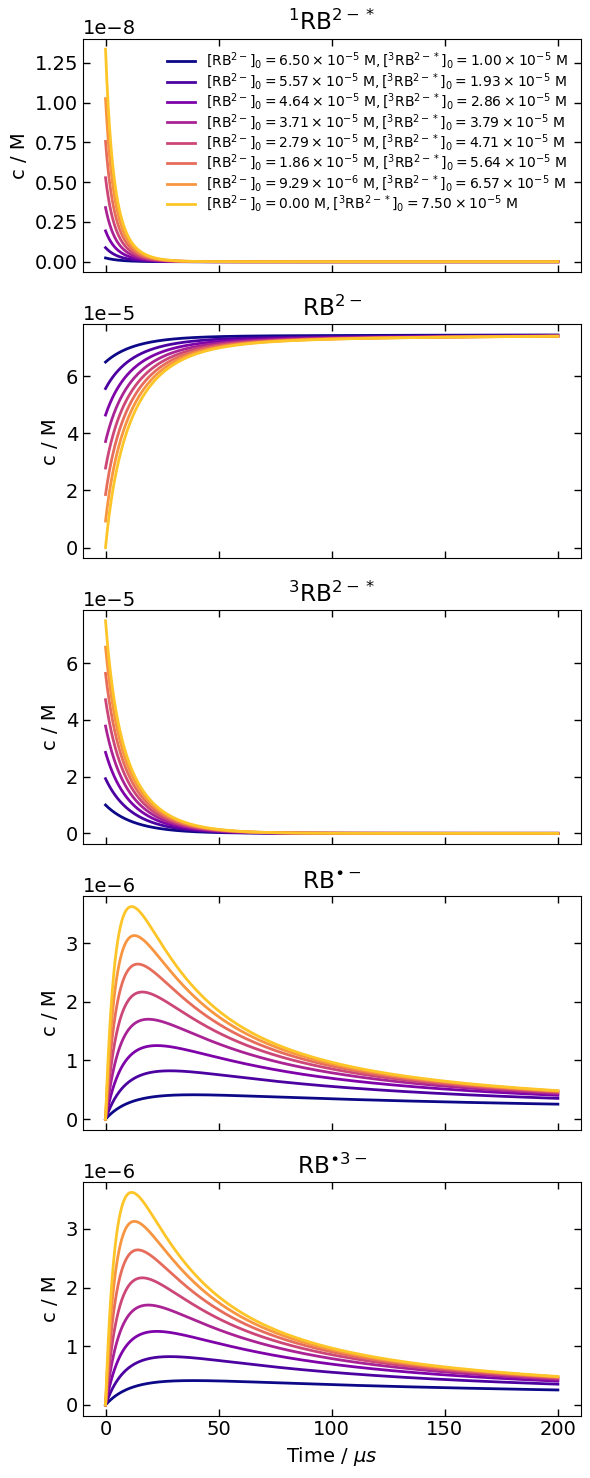

In [23]:
# parameters in MeCN, taken from https://pubs.rsc.org/en/content/articlelanding/2016/cp/c6cp01710j#!divAbstract
fl_lifetime = 2380e-12  # fluorescence lifetime
k_s_tot = 1/fl_lifetime  # total decay rate of the singlet state
k_isc = 2.77e8  # rate of intersystem crossing
phi_isc = k_isc / k_s_tot  # intersystem crossing quantum yield
# k_s_GS = (1 - phi_isc) * k_s_tot  # decay rate of singlet state to ground state

c_tot = 75e-6  # total concentration of RB
c_triplet = np.linspace(10e-6, c_tot, 8)  # various concentrations of triplet
c_GS = c_tot - c_triplet

pars.update({'c_^1RB^2-*_0': 0,
             'c_RB^2-_0': c_GS,
             'c_^3RB^2-*_0': c_triplet,
             'c_RB^bullet-_0': 0,
             'c_RB^bullet3-_0': 0,
             'k_s': 1,   # this has to be set to some positive number, cannot be None
             'k_isc': 1,  # this has to be set to some positive number, cannot be None
             'k_d': 1.01e4,
             'k_sq': 7.63e8,
             'k_redox*': 3.89e7,
             'k_TT': 9.98e8,
             'k_redox**': 1.86e8,
             'k_-eT': 1.03e10,
             'phi_isc': phi_isc,
             'tau_F': fl_lifetime
})

model.simulate_model(pars, t_max=2e-4)
model.plot_simulation_results(plot_separately=True)

### Decomposition of Endoperoxide

Here, the decomposition of aryl endoperoxide is shown. It produces singlet oxygen which can be traped with some substrate S. Singlet oxygen in solution has quite short lifetime and also, it can be physically quenched by all species contained in a solution. This is simulated in the following example.

In [26]:
str_model = """
ArO_2 --> Ar + ^1O_2                 // k_1  # production of singlet oxygen
^1O_2 --> ^3O_2                      // k_d  # decay rate of singlet oxygen through solvent
# ^1O_2 + Ar --> Ar + ^3O_2          // k_{q,Ar}     # quenching of singlet ox. by naphthalene
^1O_2 + ArO_2 --> ArO_2 + ^3O_2      // k_{q}^{\\prime}  # quenching of singlet ox. by endoperoxide
^1O_2 + S --> S + ^3O_2              // k_{q}  # quenching of singlet ox. by substrate
S + ^1O_2 -->                        // k_r    # reaction of substrate with singlet ox.
"""

model = PhotoKineticSymbolicModel.from_text(str_model)

model.print_model()
model.steady_state_approx(['^1O_2'])  # make SS approximation for singlet oxygen
pars = model.get_par_dict()   # get the parameter dictionary, we will use this to get the model the input parameters
pars

<IPython.core.display.Math object>

Eq(c_{^1O_2}(t), k_1*c_{ArO_2}(t)/(k_d + k_r*c_{S}(t) + k_{q}*c_{S}(t) + k_{q}^{\prime}*c_{ArO_2}(t)))

Eq(Derivative(c_{ArO_2}(t), t), -k_1*c_{ArO_2}(t))

Eq(Derivative(c_{Ar}(t), t), k_1*c_{ArO_2}(t))

Eq(Derivative(c_{S}(t), t), -k_1*k_r*c_{ArO_2}(t)*c_{S}(t)/(k_d + k_r*c_{S}(t) + k_{q}*c_{S}(t) + k_{q}^{\prime}*c_{ArO_2}(t)))

Eq(Derivative(c_{^3O_2}(t), t), k_1*(k_d + k_{q}*c_{S}(t) + k_{q}^{\prime}*c_{ArO_2}(t))*c_{ArO_2}(t)/(k_d + k_r*c_{S}(t) + k_{q}*c_{S}(t) + k_{q}^{\prime}*c_{ArO_2}(t)))

{'c_ArO_2_0': None,
 'c_Ar_0': None,
 'c_^1O_2_0': None,
 'c_^3O_2_0': None,
 'c_S_0': None,
 'k_1': None,
 'k_d': None,
 'k_q^prime': None,
 'k_q': None,
 'k_r': None,
 'l': 1,
 's_w': 1,
 'J_0': 1e-05,
 'FWHM': 1}

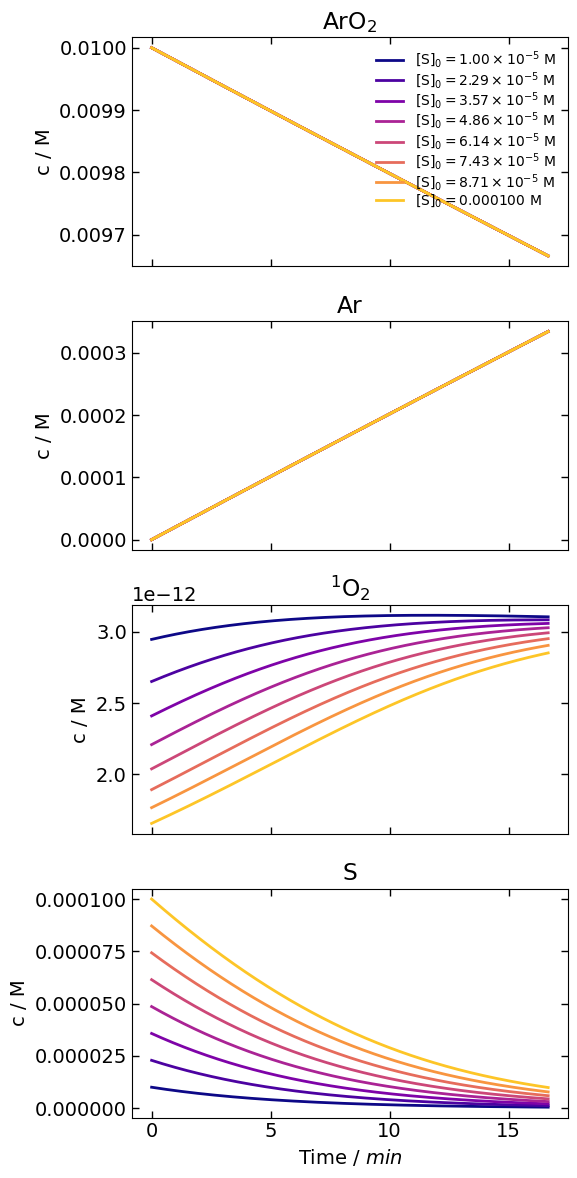

In [27]:
pars.update({'c_ArO_2_0': 1e-2,
             'c_Ar_0': 0,
             'c_^1O_2_0': 0,
             'c_^3O_2_0': 0,
             'c_S_0': np.linspace(1e-5, 1e-4, 8),
             'k_1': 3.4e-5,
             'k_d': 1/9.5e-6,
             'k_q^prime': 1e4,
             'k_q': 1e5,
             'k_r': 1e9
})

model.simulate_model(pars, constant_compartments=['^3O_2'], t_max=1e3)
model.plot_simulation_results(plot_separately=True)

### Degradation of a Sensitizer

Photosensitizer produces singlet oxygen by TT annihilation. Singlet oxygen then slowly destroys the photosensitizer. The rate laws are generated in the following example.

In [28]:
str_model = """
PS -hv-> ^1PS --> PS          // k_s  # population of singlet state and decay to GS with
^1PS --> ^3PS --> PS          // k_{isc} ; k_T
^3PS + ^3O_2 --> ^1O_2 + PS   // k_{TT}
^1O_2 --> ^3O_2               // k_d
^1O_2 + PS --> PS + ^3O_2     // k_q
PS + ^1O_2 -->                // k_r
"""

model = PhotoKineticSymbolicModel.from_text(str_model)
model.flux_type = 'Continuous'

model.print_model()
print('\n')


# make substitutions, create phi_isc and fluorescence lifetime
ks, kisc = model.symbols['rate_constants'][:2]
phi_isc, tau_F = symbols('\\phi_{isc} tau_F')

# perform the steady state approximation for singlet, triplet and singlet oxygen
# substitutions are sequential, first entry of tuple is old expression and the latter the new expression
model.steady_state_approx(['^1PS', '^3PS', '^1O_2'], subs=[(1/(ks+kisc), tau_F), (tau_F*kisc, phi_isc)])

<IPython.core.display.Math object>

Eq(J(t), J_0)

Eq(F_k(t), (1 - 1/10**(\varepsilon_{PS}*l*c_{PS}(t)))/(\varepsilon_{PS}*c_{PS}(t)))

Eq(c_{^1O_2}(t), \phi_{isc}*\varepsilon_{PS}*k_{TT}*F_k(t)*J(t)*c_{PS}(t)*c_{^3O_2}(t)/((k_T + k_{TT}*c_{^3O_2}(t))*(k_d + k_q*c_{PS}(t) + k_r*c_{PS}(t))))

Eq(c_{^1PS}(t), \varepsilon_{PS}*tau_F*F_k(t)*J(t)*c_{PS}(t))

Eq(c_{^3PS}(t), \phi_{isc}*\varepsilon_{PS}*F_k(t)*J(t)*c_{PS}(t)/(k_T + k_{TT}*c_{^3O_2}(t)))

Eq(Derivative(c_{PS}(t), t), -\phi_{isc}*\varepsilon_{PS}*k_r*k_{TT}*F_k(t)*J(t)*c_{PS}(t)**2*c_{^3O_2}(t)/((k_T + k_{TT}*c_{^3O_2}(t))*(k_d + k_q*c_{PS}(t) + k_r*c_{PS}(t))))

Eq(Derivative(c_{^3O_2}(t), t), -\phi_{isc}*\varepsilon_{PS}*k_r*k_{TT}*F_k(t)*J(t)*c_{PS}(t)**2*c_{^3O_2}(t)/((k_T + k_{TT}*c_{^3O_2}(t))*(k_d + k_q*c_{PS}(t) + k_r*c_{PS}(t))))

### The Dependence of Chemical Quantum Yields of Visible Light Photoredox Catalysis on the Irradiation Power

In the following example, the steady state kinetics of complex photoredox reaction is shown. The kinetic model and rate constants are taken from [ChemPhotoChem Paper (Open Access)](https://doi.org/10.1002/cptc.202100090). Due to the high nonlinearity of the differential equations, only stiff [BDF](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.BDF.html#ra064ca079e93-1) solver was found to simulate the model with sufficient precision.

![](https://chemistry-europe.onlinelibrary.wiley.com/cms/asset/93a4d19b-0267-4280-8e6e-4e348a710f57/cptc202100090-fig-5002-m.jpg)

In [9]:
# species = OrCat, Oct, Ena, H_2O, Imin = Imin^+, DOM, Ru = Ru(bpy)_3^{2+}, 
# RuT = ^3Ru(bpy)_3^{2+}, RuC = Ru(bpy)_3^+, Mal. = Mal\\bullet, BrMal,
# AmiR = Ami\\bullet

str_model = """
OrCat + Oct --> H_2O + Ena                                 // k_1
H_2O + Ena --> OrCat + Oct                                 // k_{-1}

# photoredox initiation
Ru(bpy)_3^{2+} -hv-> ^3Ru(bpy)_3^{2+} --> Ru(bpy)_3^{2+}   // k_2
^3Ru(bpy)_3^{2+} + Ena --> Ru(bpy)_3^+                     // k_3
Ru(bpy)_3^+ + BrMal --> Mal\\bullet + Ru(bpy)_3^{2+}       // k_4

# reactions
Ena + Mal\\bullet --> Ami\\bullet                          // k_5
Ami\\bullet + BrMal --> Imin^+ + Mal\\bullet   // k_6
Ami\\bullet + ^3Ru(bpy)_3^{2+} --> Imin^+ + Ru(bpy)_3^+    // k_7
Imin^+ + H_2O --> DOM + OrCat                              // k_8
DOM + OrCat --> Imin^+ + H_2O                              // k_{-8}
Mal\\bullet -->                                            // k_9         
"""

# instantiate the model
model = PhotoKineticSymbolicModel.from_text(str_model)
model.flux_type = "Continuous"

model.print_model()
model.pprint_equations()
pars = model.get_par_dict()

<IPython.core.display.Math object>

Eq(J(t), J_0)

Eq(F_k(t), (1 - 1/10**(\varepsilon_{Ru(bpy)_3^{2+}}*l*c_{Ru(bpy)_3^{2+}}(t)))/(\varepsilon_{Ru(bpy)_3^{2+}}*c_{Ru(bpy)_3^{2+}}(t)))

Eq(Derivative(c_{OrCat}(t), t), -k_1*c_{Oct}(t)*c_{OrCat}(t) + k_8*c_{H_2O}(t)*c_{Imin^+}(t) + k_{-1}*c_{Ena}(t)*c_{H_2O}(t) - k_{-8}*c_{DOM}(t)*c_{OrCat}(t))

Eq(Derivative(c_{Oct}(t), t), -k_1*c_{Oct}(t)*c_{OrCat}(t) + k_{-1}*c_{Ena}(t)*c_{H_2O}(t))

Eq(Derivative(c_{H_2O}(t), t), k_1*c_{Oct}(t)*c_{OrCat}(t) - k_8*c_{H_2O}(t)*c_{Imin^+}(t) - k_{-1}*c_{Ena}(t)*c_{H_2O}(t) + k_{-8}*c_{DOM}(t)*c_{OrCat}(t))

Eq(Derivative(c_{Ena}(t), t), k_1*c_{Oct}(t)*c_{OrCat}(t) - k_3*c_{Ena}(t)*c_{^3Ru(bpy)_3^{2+}}(t) - k_5*c_{Ena}(t)*c_{Mal\bullet}(t) - k_{-1}*c_{Ena}(t)*c_{H_2O}(t))

Eq(Derivative(c_{Ru(bpy)_3^{2+}}(t), t), -\varepsilon_{Ru(bpy)_3^{2+}}*F_k(t)*J(t)*c_{Ru(bpy)_3^{2+}}(t) + k_2*c_{^3Ru(bpy)_3^{2+}}(t) + k_4*c_{BrMal}(t)*c_{Ru(bpy)_3^+}(t))

Eq(Derivative(c_{^3Ru(bpy)_3^{2+}}(t), t), \varepsilon_{Ru(bpy)_3^{2+}}*F_k(t)*J(t)*c_{Ru(bpy)_3^{2+}}(t) - k_2*c_{^3Ru(bpy)_3^{2+}}(t) - k_3*c_{Ena}(t)*c_{^3Ru(bpy)_3^{2+}}(t) - k_7*c_{Ami\bullet}(t)*c_{^3Ru(bpy)_3^{2+}}(t))

Eq(Derivative(c_{Ru(bpy)_3^+}(t), t), k_3*c_{Ena}(t)*c_{^3Ru(bpy)_3^{2+}}(t) - k_4*c_{BrMal}(t)*c_{Ru(bpy)_3^+}(t) + k_7*c_{Ami\bullet}(t)*c_{^3Ru(bpy)_3^{2+}}(t))

Eq(Derivative(c_{BrMal}(t), t), -k_4*c_{BrMal}(t)*c_{Ru(bpy)_3^+}(t) - k_6*c_{Ami\bullet}(t)*c_{BrMal}(t))

Eq(Derivative(c_{Mal\bullet}(t), t), k_4*c_{BrMal}(t)*c_{Ru(bpy)_3^+}(t) - k_5*c_{Ena}(t)*c_{Mal\bullet}(t) + k_6*c_{Ami\bullet}(t)*c_{BrMal}(t) - k_9*c_{Mal\bullet}(t))

Eq(Derivative(c_{Ami\bullet}(t), t), k_5*c_{Ena}(t)*c_{Mal\bullet}(t) - k_6*c_{Ami\bullet}(t)*c_{BrMal}(t) - k_7*c_{Ami\bullet}(t)*c_{^3Ru(bpy)_3^{2+}}(t))

Eq(Derivative(c_{Imin^+}(t), t), k_6*c_{Ami\bullet}(t)*c_{BrMal}(t) + k_7*c_{Ami\bullet}(t)*c_{^3Ru(bpy)_3^{2+}}(t) - k_8*c_{H_2O}(t)*c_{Imin^+}(t) + k_{-8}*c_{DOM}(t)*c_{OrCat}(t))

Eq(Derivative(c_{DOM}(t), t), k_8*c_{H_2O}(t)*c_{Imin^+}(t) - k_{-8}*c_{DOM}(t)*c_{OrCat}(t))

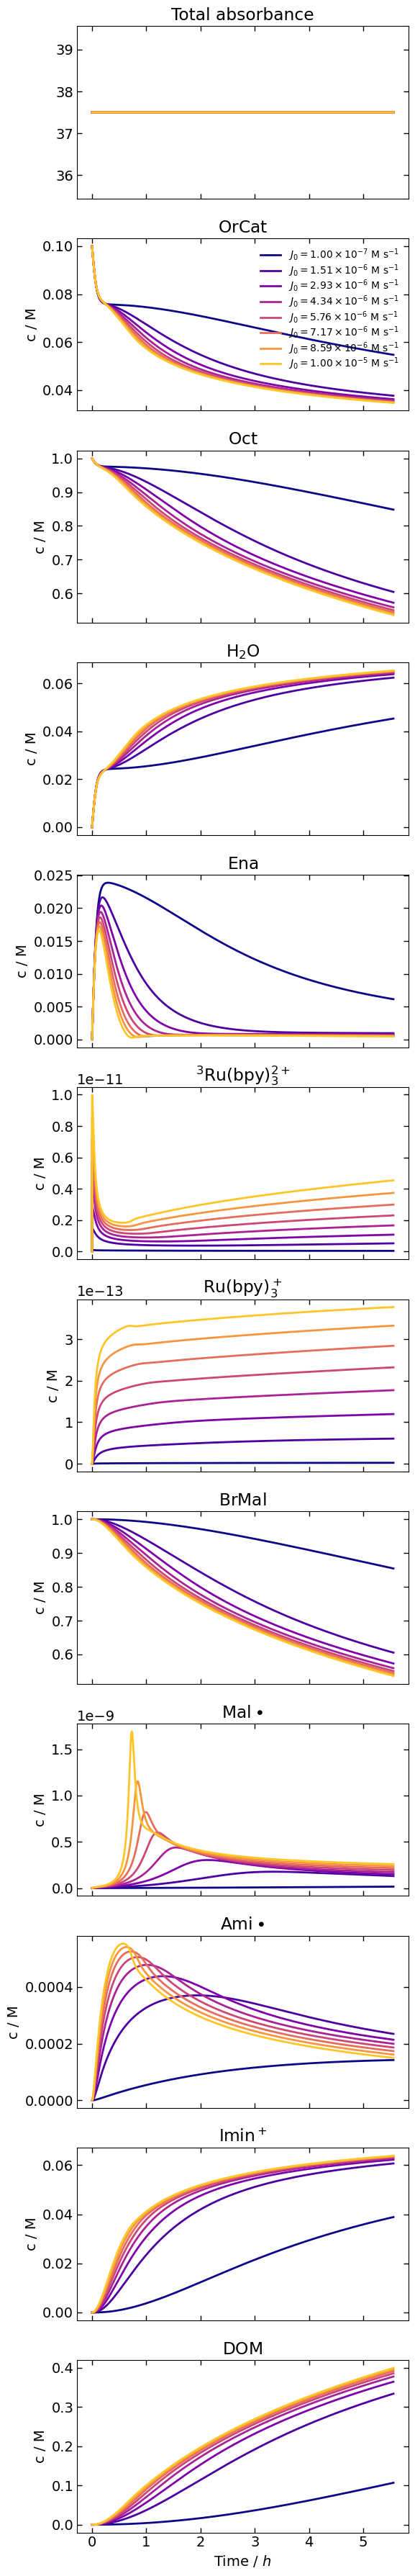

In [20]:
pars.update({'c_OrCat_0': 0.1,
             'c_Oct_0': 1,
             'c_H_2O_0': 0,
             'c_Ena_0': 0,
             'c_Ru(bpy)_3^2+_0': 2.5e-3,
             'c_^3Ru(bpy)_3^2+_0': 0,
             'c_Ru(bpy)_3^+_0': 0,
             'c_BrMal_0': 1,
             'c_Malbullet_0': 0,
             'c_Amibullet_0': 0,
             'c_Imin^+_0': 0,
             'c_DOM_0': 0,
             'k_1': 8e-4,
             'k_-1': 0.1,
             'k_2': 1e6,
             'k_3': 1e7,
             'k_4': 2.7e7,
             'k_5': 1e8,
             'k_6': 0.08,
             'k_7': 8e9,
             'k_8': 1,
             'k_-8': 0.3,
             'k_9': 103,
             'epsilon_Ru(bpy)_3^2+': 1.5e4,
             'l': 1,
             'J_0': np.linspace(1e-7, 1e-5, 8)
})

model.simulate_model(pars, t_max=2e4, constant_compartments=['Ru(bpy)_3^{2+}'], ODE_solver='BDF', t_points=1e4, default_max_step=30) # decrease the max_step of the ODE solver for precision
model.plot_simulation_results(plot_separately=True)